# Electrolyzer Data Exploratoy Data analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
    
# Set a random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.layers import Input, Conv1D, Flatten, Dense, Reshape, Conv1DTranspose
from keras.models import Model
from keras.models import clone_and_build_model
from keras.callbacks import EarlyStopping

from helper_function import *

# Deep Learning Model Implementation

In [3]:
def MaskPredModel(InputFeature):
    # Define input layer
    input_layer = Input(shape=(InputFeature.shape[1], InputFeature.shape[2]))
    
    # Encoder part
    input_layer = Input(shape=(InputFeature.shape[1], InputFeature.shape[2]))
    x = Conv1D(32, 3, activation='relu', padding='same')(input_layer)
    x = Conv1D(32, 3, activation='relu', padding='same')(x)
    shape1=x.get_shape()[1:]
    x = Flatten()(x)

    ##### First head for masked ouput prediction (linear)
    d1 = Reshape(shape1)(x)
    d1 = Conv1DTranspose(32, 3, strides=1, activation='relu', padding='same')(d1)
    d1 = Conv1DTranspose(6, 3, strides=1, activation='linear', padding='same')(d1)

    ##### Second head for masked ouput prediction (boolean)
    d2 = Reshape(shape1)(x)
    d2 = Conv1DTranspose(32, 3, strides=1, activation='relu', padding='same')(d2)
    d2 = Conv1DTranspose(6, 3, strides=1, activation='sigmoid', padding='same')(d2)
    
    # Define the autoencoder model
    autoencoder = Model(input_layer, [d1,d2])

    # Compile the model with mean squared error (MSE) loss function and Adam optimizer
    autoencoder.compile(loss=['mean_squared_error','binary_crossentropy'], optimizer='adam')
    
    return autoencoder

In [4]:
# Import the data
data = pd.read_csv("Electrolyzer_faults.csv")
X,Y,Z = sliding_window(data, window_size=10, stride=1)
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
X_sc=sc.fit_transform(X.reshape(-1,X.shape[2])).reshape(X.shape)

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, z_train, z_test = train_test_split(X_sc, Z, test_size=0.2)

# SOTA-2: Masked prediction

In [6]:
def mask_data(X, mask_percentage=0.10):
    X_masked = np.zeros(X.shape)
    Mask = np.zeros(X.shape)
    for i,x in enumerate(X):
        binary_mask = np.random.choice([1, 0], size=x.shape, p=[1 - mask_percentage, mask_percentage])
        x_masked = x * binary_mask
        X_masked[i] = x_masked
        Mask[i] = binary_mask
    return X_masked, Mask

In [7]:
x_train_mask,train_mask = mask_data(x_train, mask_percentage=0.10)
x_test_mask,test_mask = mask_data(x_test, mask_percentage=0.10)

# Pretraining using hybrid method

In [9]:
from keras.callbacks import EarlyStopping
#Pretraining using pseudo labels
psuedo_label_model = DeepLearningModel(x_train, z_train,last_layer_activation='sigmoid',loss_fn='binary_crossentropy')
# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = psuedo_label_model.fit(x_train, z_train, epochs=500, batch_size=128, validation_data=(x_test, z_test), callbacks=[early_stop])

Epoch 1/500
29/29 [==============================] - 3s 19ms/step - loss: 0.4987 - binary_accuracy: 0.8334 - val_loss: 0.2968 - val_binary_accuracy: 0.9269
Epoch 2/500
29/29 [==============================] - 0s 6ms/step - loss: 0.2278 - binary_accuracy: 0.9308 - val_loss: 0.1487 - val_binary_accuracy: 0.9502
Epoch 3/500
29/29 [==============================] - 0s 5ms/step - loss: 0.1362 - binary_accuracy: 0.9534 - val_loss: 0.1163 - val_binary_accuracy: 0.9584
Epoch 4/500
29/29 [==============================] - 0s 6ms/step - loss: 0.1108 - binary_accuracy: 0.9597 - val_loss: 0.0987 - val_binary_accuracy: 0.9616
Epoch 5/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0969 - binary_accuracy: 0.9638 - val_loss: 0.0944 - val_binary_accuracy: 0.9638
Epoch 6/500
29/29 [==============================] - 0s 6ms/step - loss: 0.0889 - binary_accuracy: 0.9664 - val_loss: 0.0870 - val_binary_accuracy: 0.9665
Epoch 7/500
29/29 [==============================] - 0s 6ms/step - lo

# Pretraining Autoencoder

Epoch 1/200
29/29 [==============================] - 2s 21ms/step - loss: 1.2615 - conv1d_transpose_1_loss: 0.6956 - conv1d_transpose_3_loss: 0.5659 - val_loss: 0.7587 - val_conv1d_transpose_1_loss: 0.3527 - val_conv1d_transpose_3_loss: 0.4059
Epoch 2/200
29/29 [==============================] - 0s 9ms/step - loss: 0.6121 - conv1d_transpose_1_loss: 0.2243 - conv1d_transpose_3_loss: 0.3878 - val_loss: 0.5149 - val_conv1d_transpose_1_loss: 0.1429 - val_conv1d_transpose_3_loss: 0.3720
Epoch 3/200
29/29 [==============================] - 0s 10ms/step - loss: 0.4948 - conv1d_transpose_1_loss: 0.1315 - conv1d_transpose_3_loss: 0.3633 - val_loss: 0.4687 - val_conv1d_transpose_1_loss: 0.1144 - val_conv1d_transpose_3_loss: 0.3543
Epoch 4/200
29/29 [==============================] - 0s 10ms/step - loss: 0.4586 - conv1d_transpose_1_loss: 0.1098 - conv1d_transpose_3_loss: 0.3487 - val_loss: 0.4419 - val_conv1d_transpose_1_loss: 0.0989 - val_conv1d_transpose_3_loss: 0.3430
Epoch 5/200
29/29 [======

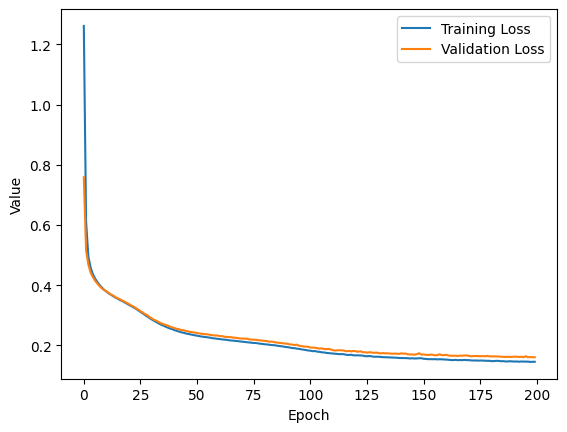

In [10]:
from keras.callbacks import EarlyStopping

mask_pred_model = MaskPredModel(x_train)
# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = mask_pred_model.fit(x_train_mask, [x_train,train_mask], epochs=200, batch_size=128, validation_data=(x_test_mask, [x_test,test_mask]), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [11]:
encoder = Model(inputs=mask_pred_model.input,outputs=mask_pred_model.layers[3].output)
encoder.compile()
encoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 6)]           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 32)            608       
                                                                 
 conv1d_3 (Conv1D)           (None, 10, 32)            3104      
                                                                 
 flatten_1 (Flatten)         (None, 320)               0         
                                                                 
Total params: 3,712
Trainable params: 3,712
Non-trainable params: 0
_________________________________________________________________


# Fine Tune the AE model

In [12]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
Y_ohe = ohe.fit_transform(Y.reshape(-1,1))

In [13]:
def FineTunedModel(nn_model,x_train,y_train,X_sc,Y_ohe,method='hybrid'):
    # nn_model.compile()

    from keras.layers import BatchNormalization
    from keras.models import clone_and_build_model

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



    if method == 'hybrid':
        model_copy= clone_and_build_model(nn_model)
        model_copy.set_weights(weights=nn_model.get_weights())
        intermediate_model = Model(inputs=model_copy.input,outputs=model_copy.layers[-2].output)
    else:
        intermediate_model = clone_and_build_model(nn_model)
        intermediate_model.set_weights(weights=nn_model.get_weights())

    for l in intermediate_model.layers:
        l.trainable=False

    fine_tuned_layers = Dense(units=64,activation='relu')(intermediate_model.output)
    output_layer = Dense(units=Y_ohe.shape[1],activation='softmax')(fine_tuned_layers)

    # Define the model
    fine_tuned_model = Model(inputs=intermediate_model.input, outputs=output_layer)

    # Compile the model with binary cross-entropy loss function and Adam optimizer
    fine_tuned_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #categorical_hinge

    #train the model with freezed layer
    fine_tuned_model.fit(x_train, y_train, epochs=500, batch_size=int(len(x_train) * 0.2), validation_data=(X_sc[::50], Y_ohe[::50]), callbacks=[early_stop], verbose=0)

    for l in fine_tuned_model.layers:
        l.trainable=True

    # Create a custom Adam optimizer with a small learning rate
    custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    # Compiling again is necessary to update the trainable parameter before training
    fine_tuned_model.compile(loss='categorical_crossentropy', optimizer=custom_optimizer, metrics=['accuracy']) #categorical_hinge

    #train the model with freezed layer
    fine_tuned_model.fit(x_train, y_train, epochs=50, batch_size=int(len(x_train) * 0.2), validation_data=(X_sc[::50], Y_ohe[::50]), callbacks=[early_stop], verbose=0)

    return fine_tuned_model

In [18]:
from sklearn.metrics import f1_score, accuracy_score

set_of_samples = [4, 8, 16, 32, 64, 90]
num_repetitions = 10

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("FineTuned Model Training")
F1_score_finetuned = np.zeros((num_repetitions, len(set_of_samples)))

for repetition in range(num_repetitions):
    print(f"**************** repetation - {repetition} ****************")
    for i, samples in enumerate(set_of_samples):
        print(f'Repetition {repetition + 1}: Training samples per class = {samples}')
 
        x_val, y_val, _ = resample(X_sc, Y, Z, samples)
        y_val = ohe.transform(y_val.reshape(-1, 1))

        fine_tuned_model = FineTunedModel(encoder,x_val,y_val,X_sc,Y_ohe,method='sota2')
        
        x_train,y_train,z_train = resample(X,Y,Z,50)
        x_train = sc.transform(x_train.reshape(-1,x_train.shape[2])).reshape(x_train.shape)
        
        y_pred = fine_tuned_model.predict(x_train)
        y_pred = ohe.inverse_transform(y_pred)
        f1 = f1_score(y_train, y_pred, average='macro')
        print(f'F1 score on whole dataset = {f1}')
        F1_score_finetuned[repetition, i] = f1

print("F1 Scores Matrix:")
print(F1_score_finetuned)

FineTuned Model Training
**************** repetation - 0 ****************
Repetition 1: Training samples per class = 4
F1 score on whole dataset = 0.6910516415512217
Repetition 1: Training samples per class = 8
F1 score on whole dataset = 0.7600633541801328
Repetition 1: Training samples per class = 16
F1 score on whole dataset = 0.8490211063989973
Repetition 1: Training samples per class = 32
F1 score on whole dataset = 0.8887483735950699
Repetition 1: Training samples per class = 64
F1 score on whole dataset = 0.9121297497771146
Repetition 1: Training samples per class = 90
F1 score on whole dataset = 0.9001827353631476
**************** repetation - 1 ****************
Repetition 2: Training samples per class = 4
F1 score on whole dataset = 0.6959008991822955
Repetition 2: Training samples per class = 8
F1 score on whole dataset = 0.7450990299157363
Repetition 2: Training samples per class = 16
F1 score on whole dataset = 0.8569008295789498
Repetition 2: Training samples per class = 3

# Save the experiment in csv file

In [19]:
mean_f1_scores_ae = np.mean(F1_score_finetuned, axis=0)
variance_f1_scores_ae= np.var(F1_score_finetuned, axis=0)

results_dict = {
    'No training samples': set_of_samples,
    'Model': ['SOA2'] * len(set_of_samples) ,
    'Mean F1 score': mean_f1_scores_ae,
    'Error': variance_f1_scores_ae
}

# Create a DataFrame from the dictionary
results_df = pd.DataFrame(results_dict)

# Save the DataFrame to a CSV file
results_df.to_csv('SOA2_mask_pred.csv', index=False)

# The proposed hybrid model

In [89]:

# Create fullySupervided NEtwork
print("Propose hybrid method")
F1_score_hybrid = np.zeros((num_repetitions, len(set_of_samples)))

for repetition in range(num_repetitions):
    for i, samples in enumerate(set_of_samples):
        print(f'Repetition {repetition + 1}: Training samples per class = {samples}')
        x_val, y_val, _ = resample(X_sc, Y,Z, samples)
        y_val_ohe = ohe.transform(y_val.reshape(-1, 1))

        hybrid_model = FineTunedModel(psuedo_label_model,x_val,y_val_ohe,X_sc,Y_ohe)
        
        x_train,y_train,z_train = resample(X,Y,Z,50)
        x_train = sc.transform(x_train.reshape(-1,x_train.shape[2])).reshape(x_train.shape)
        
        y_pred = hybrid_model.predict(x_train)
        y_pred = ohe.inverse_transform(y_pred)
        y_pred = Cascade_Hybrid_FDI(x_train,z_train,y_pred)
        f1 = f1_score(y_train, y_pred, average='macro')
        print(f'F1 score on whole dataset = {f1}')
        F1_score_hybrid[repetition, i] = f1

print("F1 Scores Matrix:")
print(F1_score_hybrid)

Propose hybrid method
Repetition 1: Training samples per class = 4
F1 score on whole dataset = 0.8465246256118677
Repetition 1: Training samples per class = 8
F1 score on whole dataset = 0.870915360624599
Repetition 1: Training samples per class = 16
F1 score on whole dataset = 0.8728452753044804
Repetition 1: Training samples per class = 32
F1 score on whole dataset = 0.890880816395274
Repetition 1: Training samples per class = 64
F1 score on whole dataset = 0.9021268156819208
Repetition 1: Training samples per class = 90
F1 score on whole dataset = 0.9123999979784452
Repetition 2: Training samples per class = 4
F1 score on whole dataset = 0.8289303141262172
Repetition 2: Training samples per class = 8
F1 score on whole dataset = 0.8590626186545322
Repetition 2: Training samples per class = 16
F1 score on whole dataset = 0.8852700309168309
Repetition 2: Training samples per class = 32
F1 score on whole dataset = 0.9063814256411964
Repetition 2: Training samples per class = 64
F1 score

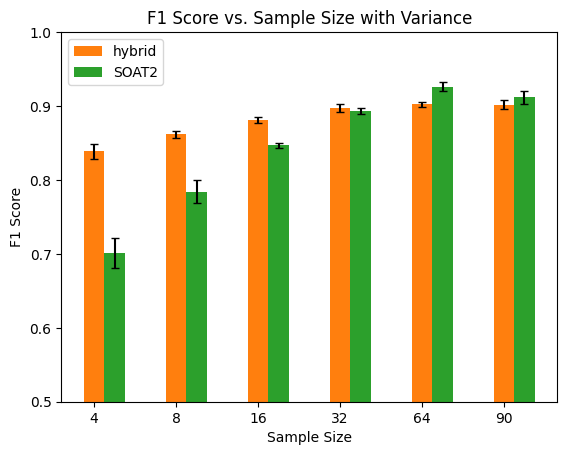

In [90]:
import numpy as np
import matplotlib.pyplot as plt

set_of_samples = [4, 8, 16, 32, 64, 90]

# Calculate the mean and variance of F1 scores for each sample size


mean_f1_scores_hybrid = np.mean(F1_score_hybrid, axis=0)
variance_f1_scores_hybrid = np.var(F1_score_hybrid, axis=0)

mean_f1_scores_ae = np.mean(F1_score_finetuned, axis=0)
variance_f1_scores_ae= np.var(F1_score_finetuned, axis=0)

# Set the width of each bar
bar_width = 0.25

# Create an array representing the x-axis positions
x = np.arange(len(set_of_samples))

# Choose colors for three classes
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Create side-by-side bar plots with error bars
plt.bar(x, mean_f1_scores_hybrid, bar_width, yerr=np.sqrt(variance_f1_scores_hybrid), capsize=3, color=colors[1], label='hybrid')
plt.bar(x + bar_width, mean_f1_scores_ae, bar_width, yerr=np.sqrt(variance_f1_scores_ae), capsize=3, color=colors[2], label='SOAT2')

plt.grid(visible=False)
plt.legend()
plt.xlabel('Sample Size')
plt.ylabel('F1 Score')
plt.ylim([0.5,1])
plt.title('F1 Score vs. Sample Size with Variance')
plt.xticks(x, [str(x) for x in set_of_samples])
plt.show()
